# <center> Analysing F1 data to predict Safety car appearances <center/>

The main purpose of this notebook is to analyse in order to identify the possible patterns of Safety car appearance in the last F1 seasons. We'll be using three datasets consisting of the race event general information, a more specific dataset with pitstop information and the dataset with the standings at each race event.

The first analyses will be focused on exploring each dataset. Then, analyses mixing up the features of different datasets would be interesting for spotting apparently underlying behaviors.

## Imports

We basically import libraries for loading, processing and visualizing data.

In [1]:
import sys
print(sys.version)

3.9.5 (default, May 18 2021, 14:42:02) [MSC v.1916 64 bit (AMD64)]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Set visualization style
#sns.set_style('darkgrid')

In [3]:
# Create color palette
c_mako = sns.color_palette("mako", 25, as_cmap=False)
c_flare = sns.color_palette("flare", 25, as_cmap=False)
c_husl = sns.color_palette("husl", 25, as_cmap=False)

## Load data

We load the files of interest. For the file containing the standings, we defined a dictionary that contains the standings through the year for each season. We make sure that the standings are stored as a pandas dataframe object type.

In [20]:
path = "../Data/"

In [21]:
calendar_df = pd.read_pickle(f'{path}Calendar_info_2018_2023.pkl')

In [22]:
with open(f'{path}Standings_info_2018_2023.pkl', 'rb') as handle:
     standings_gp = pickle.load(handle)

In [23]:
for year in range(2018, 2024): 
    standings_gp[year] = pd.DataFrame(standings_gp[year])

## Exploring analysis

First part: analyse and draw hypothesis on the behaviour of the data, comments on the patterns etc.

### Calendar 

The data we'll work on was extracted from the Fast-F1 python library and covers the race events from 2018 to 2022. We've added the 2023 season events in order to predict real life events. Information related to race incidents was retrieved from kaggle and wikipedia. The dataset is composed by basic features related to the race event (date, location, circuit, name, etc.), race information (average lap times, race incidents, etc.), and weather conditions on day race (air and track temperature, humidity, rain, etc.).

In [24]:
print(f"Raw dataset size: {calendar_df.shape}"), print(f"Actual dataset size: {calendar_df.dropna(subset = 'Location').shape}")
calendar_df.dropna(subset = 'Location', inplace = True)

Raw dataset size: (138, 24)
Actual dataset size: (126, 24)


In [25]:
calendar_df.iloc[:4,:12]

Race_number        Date   Location Circuit_type              EventName  \
0            1  2018-03-25  Melbourne        Urban  Australian Grand Prix   
1            2  2018-04-08     Sakhir    Roadtrack     Bahrain Grand Prix   
2            3  2018-04-15   Shanghai    Roadtrack     Chinese Grand Prix   
3            4  2018-04-29       Baku        Urban  Azerbaijan Grand Prix   

  Local_time_start  Season  ToD  Total_laps  Total_distance  \
0         00:00:00  2018.0  Day        58.0          303.93   
1         00:00:00  2018.0  Day        57.0          305.05   
2         06:00:00  2018.0  Day        56.0          303.11   
3         12:00:00  2018.0  Day        51.0          304.41   

           Average_lap_time  DNFs  
0 0 days 00:01:32.642810344   5.0  
1 0 days 00:01:36.876140350   3.0  
2 0 days 00:01:42.435357142   1.0  
3 0 days 00:02:02.044921568   7.0

In [26]:
calendar_df.iloc[:4,12:]

SC_NumberOfAppearances  SC_TotalLaps RedFlag  Average_lap_time_minutes  \
0                       1             2       N                       1.0   
1                       1             1       N                       1.0   
2                       1             3       N                       1.0   
3                       2            11       N                       2.0   

   Average_lap_time_seconds  Rain  Average_AirTemp  Average_Humidity  \
0                    32.643   NaN              NaN               NaN   
1                    36.876   NaN              NaN               NaN   
2                    42.435   0.0        19.446429         24.089286   
3                     2.045   0.0        16.661404         45.651754   

   Average_Pressure  Average_TrackTemp  Average_WindDirection  \
0               NaN                NaN                    NaN   
1               NaN                NaN                    NaN   
2       1018.131250          37.019643             127.392857   
3       1021.913158          25.251754             123.789474   

   Average_WindSpeed  
0                NaN  
1                NaN  
2           1.837500  
3           2.222807

Some events are non-nexistent as they occured as a side effect during the retrieval process. To reduce the bias in our analyses, we prefer to not take them into account for evaluating the completeness of the dataset. Hopefully, they represented a low share of the total events.

So... let's get started!

Description: Relatively high % of missing values overall. However they're in good conditions to be used as 20 of them are for 2023 races.

An exploration on the completeness of the dataset shows a relatively high percentage (~17%) of missing values for half of the features. 
Without any further context, we would expect that the missing of key features has a significant negative impact on the quality of the dataset. However, as the 2023 season has just started, it is completely natural to have holes in the dataset: the analysis has shown that all missing values (20 rows) correspond to the 2023 season. In particular, they are related to variables (weather and race information, race incidents) that are (very) hard to predict accurately at the start of the season. We can, however, notice that variables of the safety car and red flags are not missing, yet they are unknown at the start of the season. This disjointedness is due to how the dataset was constructed and it won't affect the rest of the study as missing rows won't be taken into account. Knowing the context, it seems for us a complete dataset as it suits for the purposes of this study.

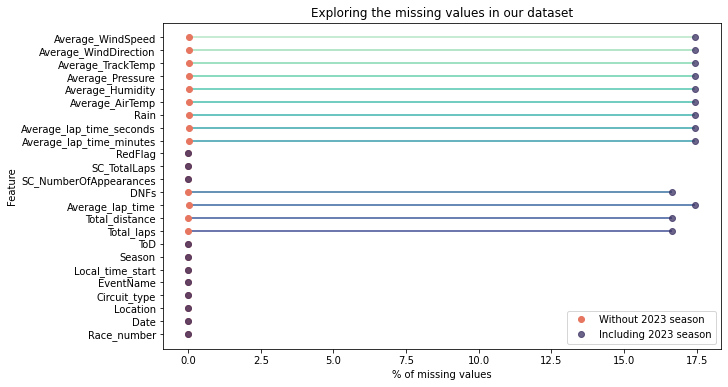

In [27]:
nullval = calendar_df.isnull().sum()
nb_events = len(calendar_df)
nullval_pct = 100*nullval/nb_events

plt.figure(figsize = (10, 6))
plt.hlines(calendar_df.columns, 0, nullval_pct, color = c_mako)
plt.plot(calendar_df.query("Season < 2023").isnull().sum()/(nb_events-20), calendar_df.columns, 'o', color = c_flare[5], \
                            label = 'Without 2023 season')
plt.plot(nullval_pct, calendar_df.columns, 'o', color = c_mako[5], alpha = .75 ,label = 'Including 2023 season')

plt.title("Exploring the missing values in our dataset")
plt.xlabel('% of missing values')
plt.ylabel('Feature')
plt.legend();

A common technique for analysing data is to study the correlation between features. Correlation helps to highlight possible patterns and will be useful for choosing the correct features to build a model. Nevertheless, context is important to establish the limits of correlation. For instance, we assume that on rainy days, there's less grip on track and the pace is slower, however, the correlation between the features **rain** and **average_lap_time** (pace) is low. So, what else are we missing? Well, we need to monitor the evolution of the rain for each race and its real effects on the pace. Also, we see that the appearance of a safety car is correlated to DNFs. However, not every DNF leads to a safety car, and not every safety car is due to a DNF (indeed, they can also appear if there's heavy rain), thus always remember the phrase **correlation does not imply causation**. 



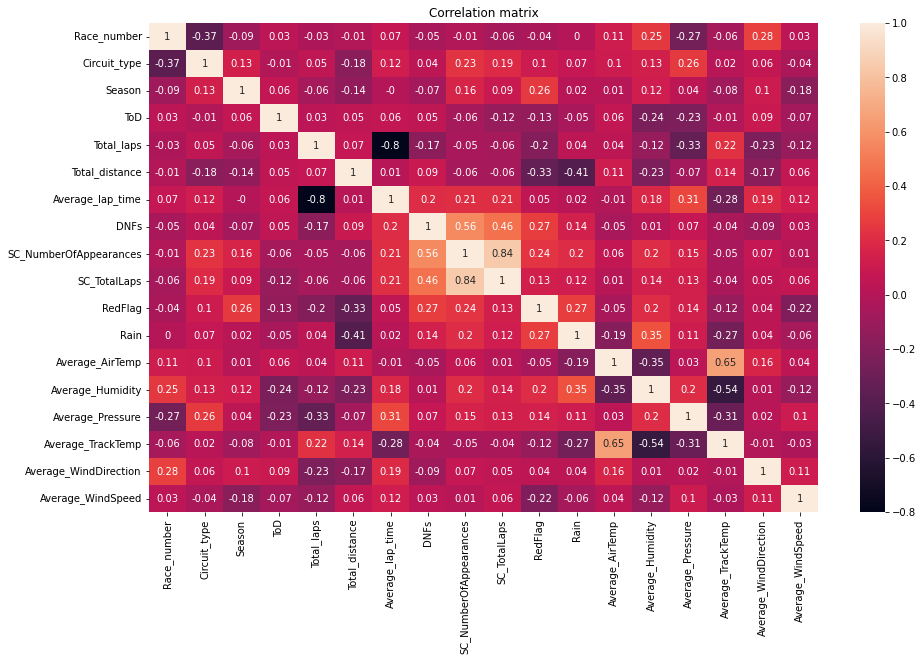

In [28]:
df_ = calendar_df.dropna().copy()
df_['RedFlag'] = df_.RedFlag.apply(lambda x: (x == 'Y')*1)
df_['ToD'] = df_.ToD.apply(lambda x: (x == 'Night')*1)
df_['Circuit_type'] = df_.Circuit_type.apply(lambda x: (x == 'Urban')*1)
df_['Average_lap_time'] = df_.Average_lap_time.apply(lambda x: np.round(x.seconds + x.microseconds*1e-6, 3))

plt.figure(figsize = (15, 9))
#sns.heatmap(calendar_df.dropna().corr().apply(lambda x: np.round(x, 2)), annot = True, cmap = c_flare)
sns.heatmap(df_.drop(['Average_lap_time_minutes', 'Average_lap_time_seconds'], axis = 1).corr()\
                                                        .apply(lambda x: np.round(x, 2)), annot = True)
plt.title("Correlation matrix");

An overall low correlation between variables is observed. Very few of these correlations are significant: track temperature tends to vary proportionally to air temperature, amongst other variables. Whereas, the quantity of DNFs impacts the occurrence of the safety car, no relevant pattern is really discernible, idem for the total number of laps involving the safety car and frequency of its occurrence (naturally, the more the safety car comes out, the more laps it will run, so it does not add any relevant information to us). This suggests that there are underlying variables that we need to explore in order to further identify potential patterns in the occurrence of a safety car.

The presented variables have a positive correlation, although notable negative correlations also exist: It appears that as lap time increases, the number of laps decreases. The reason behind this lies in the rules, which impose a minimum distance of 305 km to be covered, and that usually varies slightly from one circuit to another. Consequently, a shorter circuit will result in faster times and, equally, more laps will be completed. Also, it can be observed how humidity is one of the factors that impact the track temperature, without it being the primary one.

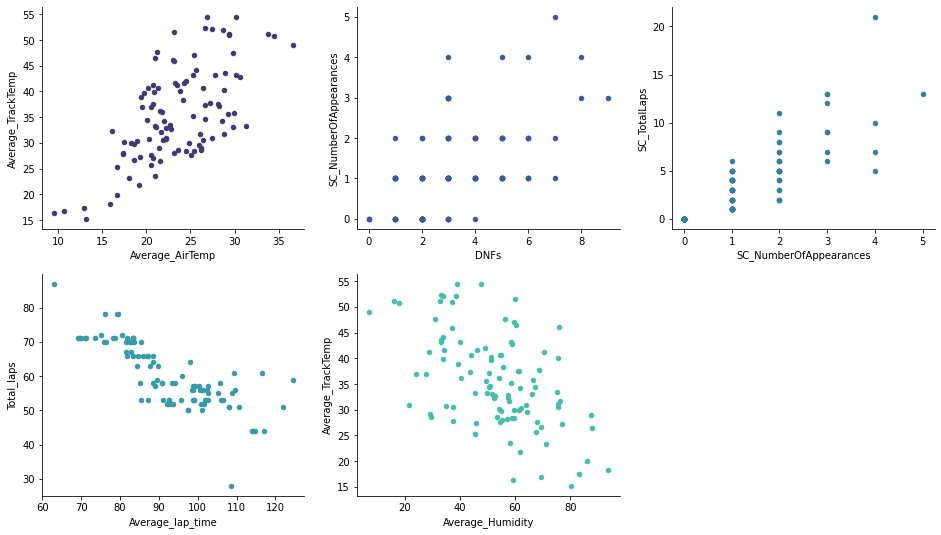

In [45]:
dic_corr = {0: ['Average_AirTemp', 'Average_TrackTemp'], 1: ['DNFs', 'SC_NumberOfAppearances'], \
            2: ['SC_NumberOfAppearances', 'SC_TotalLaps'],  3: ['Average_lap_time', 'Total_laps'], \
            4: ['Average_Humidity', 'Average_TrackTemp']}

figure, axes = plt.subplots(2, 3, figsize = (16, 9))
axes.flat[-1].set_visible(False)

for i in range(5):
    ax = axes.flatten()[i]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    df_.plot.scatter(x = dic_corr[i][0], y = dic_corr[i][1], color = c_mako[3*(i+2)], ax = ax)

Other pairs of variables can be of interest for further study, although their correlation is weak and they do not provide relevant information for achieving our objectives. For this reason, we will not enter into any further details. Such variables are: 

- Rain / Total distance
- Red Flag / Total distance
- Rain / Average Humidity
- SC Total Laps / SC Number of Appearances
- Lap time / Average Pressure
- Total Laps / Average Pressure

Since outliers (from various sources) might cause substantial bias in the analysis of the dataset, using the median rather than the average may be more effective in limiting the impact of outliers. Therefore  we will consider using box plots in order to understand the impact of outliers and gain insight into the current distribution of the data points.

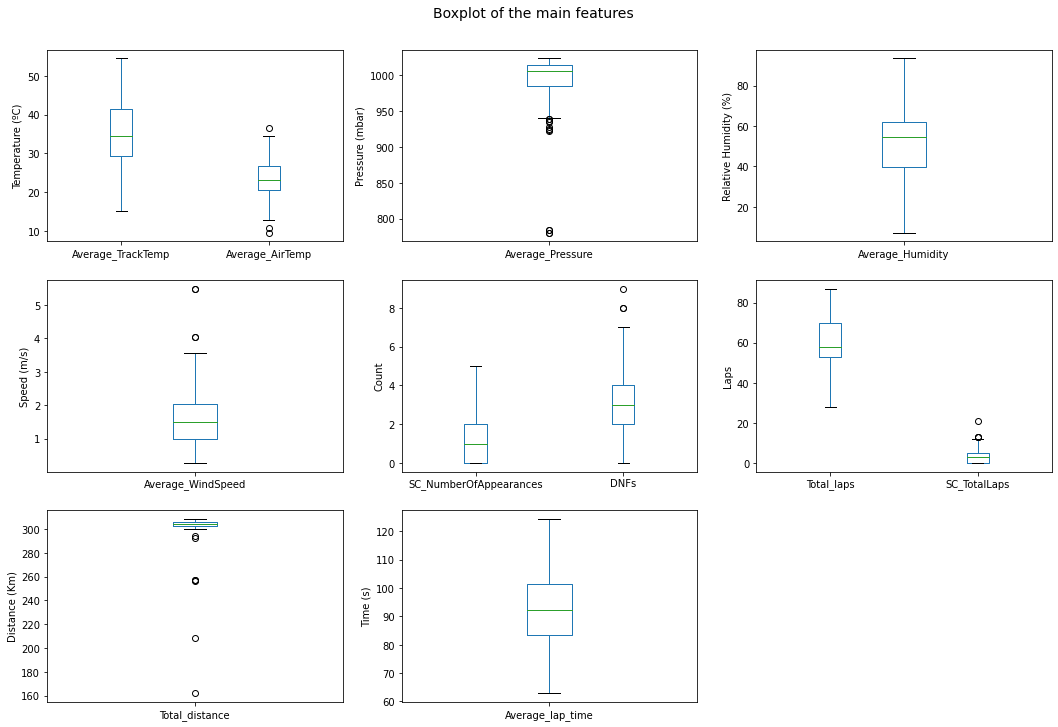

In [30]:
plt.figure(figsize = (18, 12))
plt.suptitle('Boxplot of the main features', fontsize = 14, y = 0.93)
plt.subplot(3, 3, 1)
df_[['Average_TrackTemp', 'Average_AirTemp']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Temperature (ºC)')
plt.subplot(3, 3, 2)
df_[['Average_Pressure']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Pressure (mbar)')
plt.subplot(3, 3, 3)
df_[['Average_Humidity']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Relative Humidity (%)')
plt.subplot(3, 3, 4)
df_[['Average_WindSpeed']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Speed (m/s)')
plt.subplot(3, 3, 5)
df_[['SC_NumberOfAppearances', 'DNFs']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Count')
plt.subplot(3, 3, 6)
df_[['Total_laps', 'SC_TotalLaps']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Laps')
plt.subplot(3, 3, 7)
df_[['Total_distance']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Distance (Km)')
plt.subplot(3, 3, 8)
df_[['Average_lap_time']].boxplot(rot = 0, vert = True, grid = False, ylabel = 'Time (s)');

Once analysed the box plots of non-binary variables, we have summarized the information and presented it below. To better outline the particularities of each variable, we have also drew information from the above-mentioned correlation matrix.

- In general, the average wind speed is low (a median of 1.5 m/s ~ 5.4 km/h) for most of the events. There's an appreciable variation of the average wind speed for 25% of the events. It's also important to note that the outliers match wind speeds wich are significant enough to impact the course of the race event.

- Average Track temperature and Air Temp are quite symmetric, wich indicates a normal distribution of the temperature. Also, the track temp is on average higher than air temp, the difference between both medians being around 12ºC.

- On most of races, the SC usually appears very few times, as on 75% of the races account for 2 or less appearances. On the remaining 25%, the number of appearances spans between 3 and 5, meaning caothic/high accident races, and in few cases, rain being involved in it.

- Particular attention on DNFs, the median being 3 per race. Also, a little negative skew i.e more races with 3 or more DNF cars, and few outsiders, than could be reviewed later.
- Total distance has abnormal values that compromise/make difficult the "good sight" of the box plot. These values mainly correspond to races disrupted by red flags. However, normal values range between 300 - 315 Km, making races very similar in distance.
- Total Laps are also affected by stopped races, the median being around 58 laps per race.
- Hopefully, the safety car, generally, only lasts few laps. Yet in some situations it can make it up to a 1/4 of the race laps.
- Pressure, on average, has a positive skew, and high variation, wich is followed with some anomalies. Excluding the particularity of anomalies, the plot seems to agree with reality, as events take place in different parts of the world.
- Average Humidity has negative skew. It's interesting to notice that 50% of the races had been in very humid environments.
- Average lap time is symmetric, follows a normal distribution and its median is around 92s i.e 1 min 32s. It can be influenced/altered by the rain, mainly and in residual cases, the appareance of a safety car if it lasts long enough (high number of laps).

In [31]:
df_.query("SC_NumberOfAppearances>2")[['Season', 'Location', 'ToD','Rain','RedFlag','DNFs','SC_NumberOfAppearances', 'SC_TotalLaps']]

Season    Location  ToD  Rain  RedFlag  DNFs  SC_NumberOfAppearances  \
33   2019.0  Hockenheim    0   1.0        0   7.0                       5   
37   2019.0  Marina Bay    0   0.0        0   3.0                       3   
46   2020.0   Spielberg    0   0.0        0   9.0                       3   
54   2020.0     Mugello    0   0.0        1   8.0                       3   
61   2020.0      Sakhir    0   0.0        0   3.0                       3   
89   2021.0      Jeddah    0   0.0        1   5.0                       4   
94   2022.0   Melbourne    0   0.0        0   3.0                       4   
98   2022.0      Monaco    0   1.0        1   3.0                       3   
100  2022.0    Montreal    0   0.0        0   3.0                       3   
108  2022.0  Marina Bay    1   1.0        0   6.0                       4   
112  2022.0   Sao Paulo    0   0.0        0   3.0                       3   
117  2023.0   Melbourne    0   0.0        1   8.0                       4   

     SC_TotalLaps  
33             13  
37             12  
46             13  
54              9  
61              9  
89              7  
94             21  
98              6  
100             7  
108            10  
112            13  
117             5

For more details for high SC_Appearances, based on the dataframe above, we make the following assumptions.

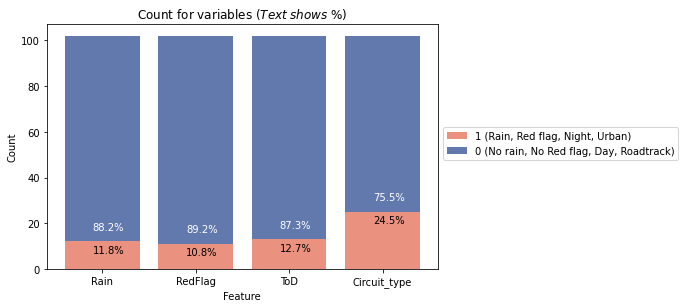

In [32]:
plt.figure(figsize = (7, 4.5))
for feature in ['Rain', 'RedFlag', 'ToD', 'Circuit_type']:
    bp = plt.bar([feature], df_[feature].sum(), color = c_flare[5], alpha = .8)
    pcgt = np.round(df_[feature].sum()/len(df_)*100, 1)
    plt.text(x = bp[0].get_x() + 0.3, y = df_[feature].sum() - 5, s = f"{pcgt}%", color = 'black')
    plt.bar([feature], len(df_) - df_[feature].sum(), bottom = df_[feature].sum(), color = c_mako[9], alpha = .8)
    plt.text(x = bp[0].get_x() + 0.3, y = df_[feature].sum() + 5, s = f"{np.round(100 - pcgt, 2)}%", color = 'white')
    plt.legend(['1 (Rain, Red flag, Night, Urban)', '0 (No rain, No Red flag, Day, Roadtrack)'], bbox_to_anchor = (1, 0.6))

plt.title('Count for variables %s'%('$(Text \; shows \; \%)$'))
plt.ylabel('Count')
plt.xlabel('Feature');

For binary variables/features, we display/show the occurrences in percentage, as a way to measure the potential influence on global factors, as the race evolution changes drastically under different circunstances. Most of races (~90%) show the pattern: No rain, No red flags, Day time, and for 75% percent of races are done in traditional circuits (roadtracks).

↓ Make others with weather? DNFs? SC appearance?

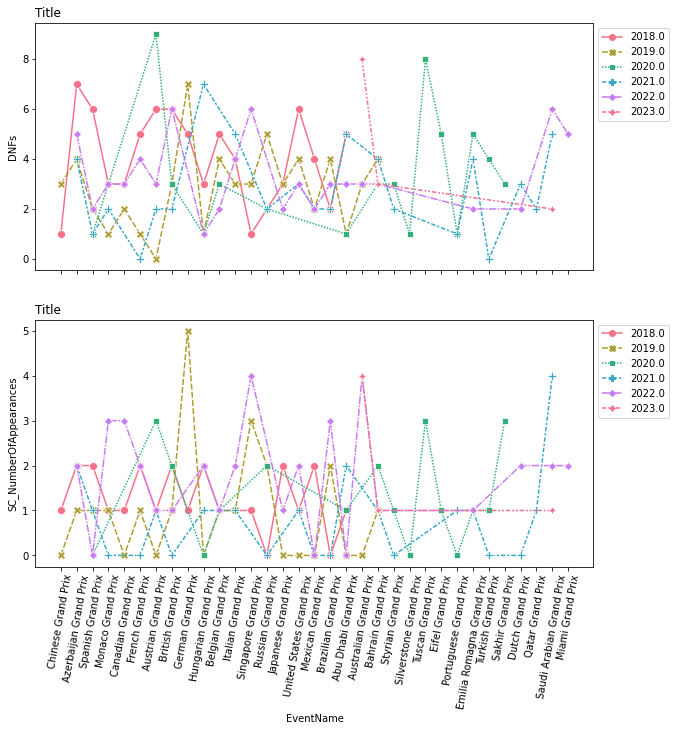

In [33]:
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
g = sns.lineplot(df_, x = 'EventName', y = 'DNFs', hue = 'Season', palette = "husl", style = 'Season', \
             markers = True, markersize = 8)
g.set(xticklabels=[])
g.set(xlabel = None)
plt.title('Title', loc = 'left')
plt.legend(bbox_to_anchor = (1, 1))
#plt.xticks(labels = None, rotation = 80)

plt.subplot(2, 1, 2)
sns.lineplot(df_, x = 'EventName', y = 'SC_NumberOfAppearances', hue = 'Season', palette = "husl", style = 'Season', \
             markers = True, markersize = 8)
plt.title('Title', loc = 'left')
plt.xticks(rotation = 80)
plt.legend(bbox_to_anchor = (1, 1));

### Pitstop

Too large to handle at the moment.

### Standings

Sprint Points are not taken into account

In [34]:
# Adding DNF
for year in range(2018, 2023):
    standings_gp[year]['DNF'] = standings_gp[year].Status.apply(lambda x: 1 - 1*( x == 'Finished' or 'Lap' in x))

standings_gp[2020]['Team_standings'].loc[307] = standings_gp[2020].loc[306].Team_standings
standings_gp[2020]['Team_standings'].loc[320] = standings_gp[2020].loc[319].Team_standings
standings_gp[2020]['Team_standings'].loc[333] = standings_gp[2020].loc[335].Team_standings

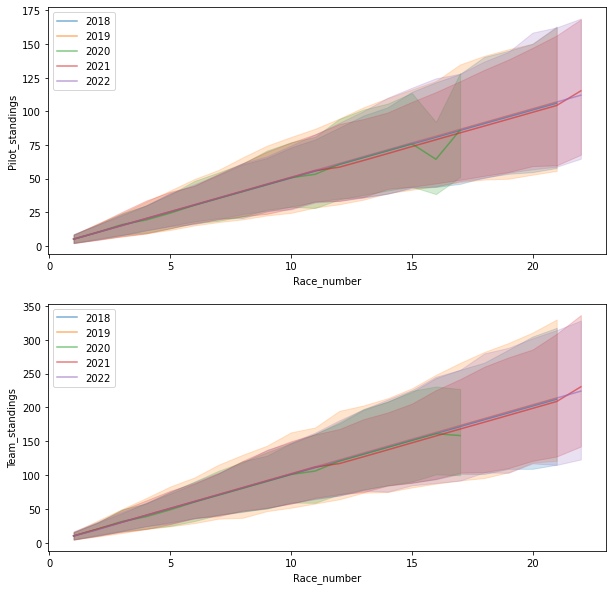

In [35]:
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
for year in range(2018, 2023):
    sns.lineplot(standings_gp[year], x = 'Race_number', y = 'Pilot_standings', label = year, alpha = 1 - .1*i)

plt.legend(loc = 'upper left')

plt.subplot(2, 1, 2)
for year in range(2018, 2023):
    sns.lineplot(standings_gp[year], x = 'Race_number', y = 'Team_standings', label = year, alpha = 1 - .1*i)

plt.legend(loc = 'upper left');

We notice that 2020 was a shortenned season (17 races) due to the pandemic. In general, the mean evolution is similar for all seasons,  meaning that no big changes in standings have really happened between seasons. We can also remark that through the 2021 season, and more particularly from the fifth race onwards, the envelope (95-confidence interval) is a bit narrower compared to the rest of the seasons, meaning that deviation from the mean is smaller i.e top team drivers have lesser points than previous seasons and bottom team drivers have more. An abnormality is observed between the for the 16th race as a consequence of Hamilton not being present in that race, data error.

Very similar charts. However, slight differences can be appreciated. For instance, teams are closer to the mean than drivers, etc.

In [38]:
standings_all.Laps_completed.astype(int).describe()

count    2058.000000
mean       54.155491
std        17.717771
min         0.000000
25%        52.000000
50%        56.000000
75%        66.000000
max        87.000000
Name: Laps_completed, dtype: float64

DNFs per driver (evolution? boxplot? barplot?)

In [ ]:
to_rename = {'Alfa Romeo Racing': 'Alfa Romeo', 'Alfa Romeo Racing-Ferrari': 'Alfa Romeo', 'Alfa Romeo-Ferrari': 'Alfa Romeo',\
    'AlphaTauri-Honda': 'AlphaTauri', 'AlphaTauri-RBPT': 'AlphaTauri', 'Alpine-Renault': 'Alpine', \
    'Aston Martin Aramco-Mercedes': 'Aston Martin', 'McLaren-Mercedes': 'McLaren', 'Racing Point-BWT Mercedes': 'Racing Point',\
    'Red Bull Racing-Honda': 'Red Bull Racing'}

In [ ]:
import plotly.graph_objects as go

layout = go.Layout(title=go.layout.Title(text="Title"), xaxis=dict(title="X Label"), yaxis=dict(title="Y label"))
fig = go.Figure(layout=layout)

c_list = ['blue', 'red', 'green', 'purple', 'orange']
#c_list = [f'rgb{c_flare[21 - (5*i)]}' for i in range(5)]

for i, year in enumerate(range(2018, 2023)):
    df_info = standings_gp[year]
    mean_dnf = df_info.DNF.sum()/len(set(df_info.TeamName))
    df_info['TeamName'] = df_info.TeamName.apply(lambda x: to_rename[x] if x in to_rename.keys() else x)
    fig.add_trace(go.Histogram(histfunc="sum", y =df_info.DNF, x= df_info.TeamName, name = year, opacity = 0.8)) #, marker_color = c_list[i]))
    fig.add_hline(y=mean_dnf, line_width=1, line_dash="dot", line_color = c_list[i], name = 'Mean')

#fig.add_trace(go.Histogram(histfunc="sum", y=standings_gp[2019].DNF, x=standings_gp[2019].TeamName))
fig.update_layout(autosize=False, width=1000, height=500)

fig.show()

In [ ]:
c_husl = sns.color_palette('husl', 15)
#c_husl = sns.color_palette("Paired", 16)

In [37]:
standings_all = pd.concat([pd.concat([standings_gp[year], pd.DataFrame({'Season': len(standings_gp[year])*[year]})], axis = 1)\
                           for year in range(2018, 2023)])

standings_all['Position'] = standings_all.Position.apply(int)
standings_all['GridPosition'] = standings_all.GridPosition.apply(int)

fig = px.box(standings_all, x = 'Abbreviation', y = 'Position', color = 'Season', title = 'Title', width=4000, height=500)
#sns.boxplot(standings_all, x = 'Abbreviation', y = 'GridPosition', flierprops={"marker": "x"})
fig.show()
#plt.title(f"Race results of {year} season")

#Try to have evolution for each in the same boxplot or comparison race result / grid for each driver  

In [ ]:
c_team = {'Ferrari': '#DC0000', 'Mercedes': '#00D2BE', 'Red Bull Racing': '#0600EF', 'McLaren': '#FF8700', 'Renault': '#FFF500',
    'Force India': '#E596C8', 'Sauber': '#DE3146', 'Williams': '#005AFF', 'Toro Rosso': '#5600EF' , 'Haas F1 Team': '#AEAEAE',
       'Racing Point': '#F596C8', 'Alfa Romeo': '#9B0000', 'AlphaTauri': '#2B4562', 'Aston Martin': '#006F62',
       'Alpine': '#0090FF'}

In [ ]:
for i in c_team.keys():
    x, y = np.random.rand(2, 1)
    plt.scatter(x, y, color = c_team[i], label = i)
plt.legend(bbox_to_anchor = (1, 1), ncols = 4)